<a href="https://colab.research.google.com/github/asandino87/LungCT/blob/v1.9/LungSegm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Input,layers, models
from tensorflow.keras.layers import Conv2DTranspose,Dropout,Conv2D,BatchNormalization, Activation,MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import math
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
input_dir = '/content/drive/My Drive/LungCT/train/'
mask_dir = '/content/drive/My Drive/LungCT/mask/'


val_dir = '/content/drive/My Drive/LungCT/val_set/'
mask_val_dir = '/content/drive/My Drive/LungCT/mask_val/'

In [5]:
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

image_datagen_val = ImageDataGenerator(rescale=1./255)
mask_datagen_val = ImageDataGenerator(rescale=1./255)


target_size=(512//4, 512//4)

image_generator = image_datagen.flow_from_directory(
    input_dir,
    class_mode=None, target_size=target_size,
    seed=1)

mask_generator = mask_datagen.flow_from_directory(
    mask_dir,
    class_mode=None, target_size=target_size,
    seed=1)

image_generator_val = image_datagen_val.flow_from_directory(
    val_dir,
    class_mode=None, target_size=target_size,
    seed=1)

mask_generator_val = mask_datagen_val.flow_from_directory(
    mask_val_dir,
    class_mode=None, target_size=target_size,
    seed=1)


steps = image_generator.n//image_generator.batch_size
steps_val = image_generator_val.n//image_generator_val.batch_size


train_generator = zip(image_generator, mask_generator)
val_generator = zip(image_generator_val, mask_generator_val)

Found 955 images belonging to 1 classes.
Found 955 images belonging to 1 classes.
Found 398 images belonging to 1 classes.
Found 398 images belonging to 1 classes.


(32, 128, 128, 3)


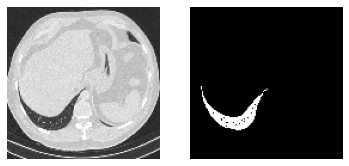

In [6]:
for _ in range(1):
    img = image_generator.next()
    mask = mask_generator.next()
    
    print(img.shape)
    plt.figure(1)
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(img[0])
    plt.subplot(1,2,2)
    plt.imshow(mask[0])
    plt.axis('off')
    plt.show()


In [7]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = tf.concat([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=2, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=1, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('sigmoid')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [8]:
model = Unet(512//4, 512//4, nclasses=2, filters=16)

model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [9]:
# learning rate schedule

def step_decay(epoch):
	initial_lrate = 1e-3
	drop = 0.1
	epochs_drop = 50
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [10]:

lr = LearningRateScheduler(step_decay)
es = EarlyStopping(patience=50,mode='min', verbose=1)
checkpoint_path ='/content/drive/My Drive/LungCT/' + 'exp.h5'

mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1 , save_best_only=True, mode='min')

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
history = model.fit(train_generator,
                    steps_per_epoch=steps,
                    validation_data=val_generator,
                    validation_steps=steps_val,
                    epochs=200,
                    verbose=2,
                    callbacks=[es,mc,lr])

Epoch 1/200
29/29 - 18s - loss: 0.5297 - accuracy: 0.8635 - val_loss: 59.5007 - val_accuracy: 0.1359

Epoch 00001: val_loss improved from inf to 59.50072, saving model to /content/drive/My Drive/LungCT/exp.h5
Epoch 2/200
29/29 - 10s - loss: 0.4616 - accuracy: 0.9763 - val_loss: 10.1225 - val_accuracy: 0.1523

Epoch 00002: val_loss improved from 59.50072 to 10.12254, saving model to /content/drive/My Drive/LungCT/exp.h5
Epoch 3/200
29/29 - 10s - loss: 0.4433 - accuracy: 0.9836 - val_loss: 0.7633 - val_accuracy: 0.6511

Epoch 00003: val_loss improved from 10.12254 to 0.76330, saving model to /content/drive/My Drive/LungCT/exp.h5
Epoch 4/200
29/29 - 10s - loss: 0.4253 - accuracy: 0.9883 - val_loss: 0.5438 - val_accuracy: 0.9080

Epoch 00004: val_loss improved from 0.76330 to 0.54383, saving model to /content/drive/My Drive/LungCT/exp.h5
Epoch 5/200
29/29 - 10s - loss: 0.4113 - accuracy: 0.9906 - val_loss: 0.4715 - val_accuracy: 0.9848

Epoch 00005: val_loss improved from 0.54383 to 0.4714

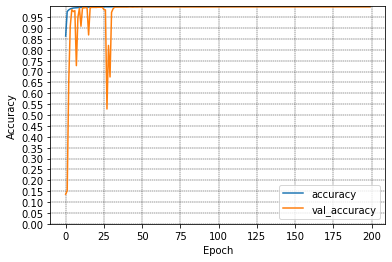

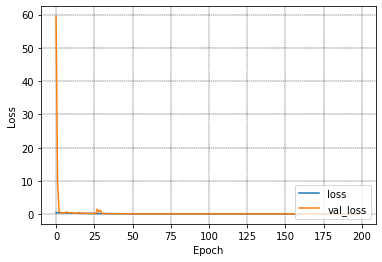

In [13]:
import numpy as np

plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(color='k', linestyle='--', linewidth=0.4)
plt.legend(loc='lower right')
#plt.savefig(dir + 'accuracy_CNN_ ' + Exp +  '.png')

plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
#plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(color='k', linestyle='--', linewidth=0.4)
plt.legend(loc='lower right')
#plt.savefig(dir + 'loss_CNN_' + Exp + '.png')